In [1]:
!nvidia-smi

Mon May 15 06:21:15 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 516.94       Driver Version: 516.94       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| 45%   33C    P0    N/A /  75W |   1650MiB /  4096MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Import Libary
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

from matplotlib.ticker import MaxNLocator

import nltk
from nltk.tokenize import word_tokenize
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory, StopWordRemover, ArrayDictionary
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

from wordcloud import WordCloud

import gensim
from gensim import models
from gensim.models.ldamodel import LdaModel
from gensim.models import Phrases, CoherenceModel
import gensim.corpora as corpora

# nltk.download('punkt')
# nltk.download('stopwords')
# nltk.download('wordnet')
# nltk.download('omw-1.4')

# Load Dataset

In [3]:
# Load Dataset
df = pd.read_csv("../dataset/gmaps_review_dataset - labelling - review.csv")

In [4]:
# Show first 5 rows
df.head()

,id,PIC,datetime,date status,scrapped_at,location,rating,text,aksesibilitas,fasilitas (akomodasi dan amenitas),aktivitas (atraksi dan aktivitas)
0,47d0cdd937754bd6b860f89b2bab1dbb,Fakhri,2022-05-15 11:58:43,Valid,2023-02-15 11:58:43,Curug Malela,4,Akses jalannya waktu itu masih sulit di jangka...,2,0,0
1,4804acd6c05e4f89b098e2ca35019419,Fakhri,2022-08-15 11:58:43,Valid,2023-02-15 11:58:43,Curug Malela,5,"Perjalanan yg bnr"" bikin Syahduu ,, dr Tempat ...",1,0,1
2,3eae265bf32a45eca31765a4145bc030,Fakhri,2022-03-15 11:58:43,Valid,2023-02-15 11:58:43,Curug Malela,5,"Minggu 13 februari 2022 ,\n\ngas santai pakai ...",1,2,1
3,61037dbdb7b14045be49d4494e95cf05,Fakhri,2022-05-15 11:58:44,Valid,2023-02-15 11:58:44,Curug Malela,5,7 mei 2022\nTouring bari mudik\nMntap perjalan...,1,0,1
4,a2c9e817e2b949c6880f971f43a11d2f,Fakhri,2022-08-15 11:58:44,Valid,2023-02-15 11:58:44,Curug Malela,5,Perjalanan touring motor dari bekasi melewati ...,0,0,1


In [5]:
# Rename column
df = df.rename(columns={'date status':'status'})

In [6]:
# Show lenght and type of columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13587 entries, 0 to 13586
Data columns (total 11 columns):
 #   Column                              Non-Null Count  Dtype 
---  ------                              --------------  ----- 
 0   id                                  13587 non-null  object
 1   PIC                                 13587 non-null  object
 2   datetime                            13587 non-null  object
 3   status                              13587 non-null  object
 4   scrapped_at                         13587 non-null  object
 5   location                            13587 non-null  object
 6   rating                              13587 non-null  int64 
 7   text                                13587 non-null  object
 8   aksesibilitas                       13587 non-null  int64 
 9   fasilitas (akomodasi dan amenitas)  13587 non-null  object
 10  aktivitas (atraksi dan aktivitas)   13587 non-null  object
dtypes: int64(2), object(9)
memory usage: 1.1+ MB


In [7]:
# Convert column type to datetime type
df['datetime'] = df['datetime'].apply(pd.to_datetime)

# Preprocessing

## Data Filtering

In [8]:
mask = (df['datetime'] >= '2019-1-1')
df = df.loc[mask]

In [9]:
len(df)

12569

In [10]:
df = df.drop(columns=['PIC', 'scrapped_at', 'rating', 'aksesibilitas', 'fasilitas (akomodasi dan amenitas)', 'aktivitas (atraksi dan aktivitas)'])

In [11]:
df = df[df['location'] != 'Situ Lembang Dano']

In [12]:
df = df[df['status'] != 'Invalid']

In [13]:
df = df.drop_duplicates(subset=['text'])

In [14]:
len(df)

11658

## Data Cleaning

In [15]:
def get_translate_text(text):
    keyword = ['(Diterjemahkan oleh Google)', '(Asli)']
    if keyword[0] in text and keyword[1] in text:
        text = text[text.find(keyword[0]) + len(keyword[0]):text.rfind(keyword[1])]
    elif keyword[0] in text and keyword[1] not in text:
        text = text[text.find(keyword[0]) + len(keyword[0]):]
    return text 

In [16]:
def clean_text(text):
    emoji_pattern = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                            "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r' ', text) # no emoji
    text = text.lower() #to lowercase
    text = re.sub('\n', ' ', text) #remove \n
    text = re.sub(r'[^\w\s]', ' ', text) #remove punctuation
    text = re.sub("\d+", "", text) #remove number
    text = re.sub(' +', ' ', text) #remove multiple whitespace
    
    if re.search(r'([a-zA-Z])\1{2,}', text): # Spell
        text = re.sub(r'([a-zA-Z])\1{2,}','\\1', text)
        
    return text

In [17]:
df['text_preprocess'] = df['text'].apply(get_translate_text)
df['text_preprocess'] = df['text_preprocess'].apply(clean_text)
df['len_char'] = df['text_preprocess'].apply(lambda x: len(x))
df['len_word'] = df['text_preprocess'].apply(lambda x: len(x.split(' ')))

In [18]:
df.head()

,id,datetime,status,location,text,text_preprocess,len_char,len_word
0,47d0cdd937754bd6b860f89b2bab1dbb,2022-05-15 11:58:43,Valid,Curug Malela,Akses jalannya waktu itu masih sulit di jangka...,akses jalannya waktu itu masih sulit di jangka...,84,13
1,4804acd6c05e4f89b098e2ca35019419,2022-08-15 11:58:43,Valid,Curug Malela,"Perjalanan yg bnr"" bikin Syahduu ,, dr Tempat ...",perjalanan yg bnr bikin syahduu dr tempat park...,110,19
2,3eae265bf32a45eca31765a4145bc030,2022-03-15 11:58:43,Valid,Curug Malela,"Minggu 13 februari 2022 ,\n\ngas santai pakai ...",minggu februari gas santai pakai motor dari da...,1993,338
3,61037dbdb7b14045be49d4494e95cf05,2022-05-15 11:58:44,Valid,Curug Malela,7 mei 2022\nTouring bari mudik\nMntap perjalan...,mei touring bari mudik mntap perjalanan sungg...,162,25
4,a2c9e817e2b949c6880f971f43a11d2f,2022-08-15 11:58:44,Valid,Curug Malela,Perjalanan touring motor dari bekasi melewati ...,perjalanan touring motor dari bekasi melewati ...,152,23


In [19]:
df[df['id'] == '3452054e89614078a257967adbbee4b6']

,id,datetime,status,location,text,text_preprocess,len_char,len_word
8340,3452054e89614078a257967adbbee4b6,2021-02-15 14:13:20,Valid,Sanghyang Kenit,Kerennnn 😍 …,keren,6,2


## Tokenizing

In [20]:
df['tokens'] = df['text_preprocess'].apply(lambda x: word_tokenize(x))

In [21]:
df['tokens']

0        [akses, jalannya, waktu, itu, masih, sulit, di...
1        [perjalanan, yg, bnr, bikin, syahduu, dr, temp...
2        [minggu, februari, gas, santai, pakai, motor, ...
3        [mei, touring, bari, mudik, mntap, perjalanan,...
4        [perjalanan, touring, motor, dari, bekasi, mel...
                               ...                        
13582    [hanya, mencoba, sarapan, dan, offroad, pakai,...
13583    [pngnnya, ksni, petik, strawberry, tpi, lgi, g...
13584    [ksini, cuma, main, aja, dan, lihat, lihat, su...
13585    [luar, biasa, mantap, makan, prasmanan, ny, mu...
13586             [tempat, dan, suasananya, sejuk, banget]
Name: tokens, Length: 11658, dtype: object

stop_words = StopWordRemoverFactory().get_stop_words()## Stopwords removal

In [22]:
# stop_words = StopWordRemoverFactory().get_stop_words()
# extend_stopword = [
#     'pas', 'yg', 'tp', 'rb', 'km', 'tp', 'dg', 'dr',
#     'bagu','bagus','bagusnya',
#     'banyaknya','banyakny','banyak',
#     'jlan','jalan',
#     'masuk','tempat',
#     'atas','sana','karna','sama','saya','sudah','udah','mungkin', 'tuji','jadi','saja','sini','kalo','kalau',
#     'untuk','semua','buat','bisa','cuma','sangat','buat','unutk','paling','cukup','naik','ribu','sekali',
#     'benar','kesini','turun','sera','sayangny','anjur','mending','dapat', 'punya','mana','sekitar',
#     'dapet','coba','bukan','sebut','sampe','tuju','hingga','beberapa','banget',
#     'utk','gak','adl','dll','coba','klo','nya','pas','per','bnr','udh','lua','aja','bgt','lalu','krn','mau',
# ]

# stop_words += extend_stopword

# df['tokens'] = df['tokens'].apply(lambda x: [w for w in x if not w in stop_words])

In [23]:
from nltk.corpus import stopwords 

stop_words = sorted(list(set(stopwords.words('indonesian')) - set(['jauh'])))
stop_words.extend([
    'pas', 'yg', 'tp', 'rb', 'km', 'tp', 'dg', 'dr', 'nya',
    # 'bagu','bagus','bagusnya',
    # 'banyaknya','banyakny','banyak',
    # 'jlan','jalan',
    # 'masuk','tempat',
    # 'atas','sana','karna','sama','saya','sudah','udah','mungkin', 'tuji','jadi','saja','sini','kalo','kalau',
    # 'untuk','semua','buat','bisa','cuma','sangat','buat','unutk','paling','cukup','naik','ribu','sekali',
    # 'benar','kesini','turun','sera','sayangny','anjur','mending','dapat', 'punya','mana','sekitar',
    # 'dapet','coba','bukan','sebut','sampe','tuju','hingga','beberapa','banget',
    # 'utk','gak','adl','dll','coba','klo','nya','pas','per','bnr','udh','lua','aja','bgt','lalu','krn','mau',
])

df['tokens'] = df['tokens'].apply(lambda x: [w for w in x if not w in stop_words])

In [24]:
df['tokens']

0        [akses, jalannya, sulit, jangkau, perjalanan, ...
1        [perjalanan, bnr, bikin, syahduu, parkir, loka...
2        [minggu, februari, gas, santai, pakai, motor, ...
3        [mei, touring, bari, mudik, mntap, perjalanan,...
4        [perjalanan, touring, motor, bekasi, melewati,...
                               ...                        
13582    [mencoba, sarapan, offroad, pakai, land, rover...
13583    [pngnnya, ksni, petik, strawberry, tpi, lgi, g...
13584    [ksini, main, aja, lihat, lihat, suasananya, e...
13585                [mantap, makan, prasmanan, ny, murah]
13586                          [suasananya, sejuk, banget]
Name: tokens, Length: 11658, dtype: object

## Stemming

In [25]:
factory = StemmerFactory()
stemmer = factory.create_stemmer()
 
df['tokens'] = df['tokens'].apply(lambda x: stemmer.stem(' '.join(x)).split(' '))

In [26]:
df['tokens']

0        [akses, jalan, sulit, jangkau, jalan, tuji, cu...
1        [jalan, bnr, bikin, syahduu, parkir, lokasi, c...
2        [minggu, februari, gas, santai, pakai, motor, ...
3        [mei, touring, bari, mudik, mntap, jalan, sung...
4        [jalan, touring, motor, bekas, lewat, track, s...
                               ...                        
13582    [coba, sarap, offroad, pakai, land, rover, mak...
13583    [pngnnya, ksni, petik, strawberry, tpi, lgi, g...
13584    [ksini, main, aja, lihat, lihat, suasana, emg,...
13585                [mantap, makan, prasmanan, ny, murah]
13586                             [suasana, sejuk, banget]
Name: tokens, Length: 11658, dtype: object

In [27]:
df.loc[df['id'] == '9d6e15357c5441078e33cf373d9b272d']

,id,datetime,status,location,text,text_preprocess,len_char,len_word,tokens
1049,9d6e15357c5441078e33cf373d9b272d,2020-02-15 12:32:57,Valid,Taman Hutan Jayagiri Lembang,Good place to hiking with friends or family. T...,tempat yang bagus untuk hiking bersama teman ...,108,19,"[bagus, hiking, teman, keluarga, warung, jual,..."


## Additional Step

In [28]:
def reduction_character_less_than_n(text):
    new_text = []
    char_less_than_threshold = 2
    length_word = len(text)
    for word_i in range(length_word):
        if len(text[word_i]) > char_less_than_threshold:
            new_text += [text[word_i]]
    
    return new_text

In [29]:
df['tokens'] = df['tokens'].apply(reduction_character_less_than_n)

In [30]:
# text = ['jalan', 'lumayan', 'jalur', 'mobil', 'pas', 'pas', 'mobil', 'parkir', 'jalan', 'kaki', 'ojeg', 'km', 'curug', 'tp', 'bayar', 'dg', 'pandang', 'curug', 'indah']
# text_new = reduction_character_less_than_n(text)
# text_new

In [31]:
df = df.drop_duplicates(subset=['text_preprocess'])

In [32]:
len(df)

11567

In [33]:
df['len_token'] = df['tokens'].apply(lambda x: len(x))

In [34]:
df[df['len_token'] <= 3]

,id,datetime,status,location,text,text_preprocess,len_char,len_word,tokens,len_token
49,457feb4e6161474f829dd51b07af05fe,2023-01-15 11:58:46,Valid,Curug Malela,Niagara kecil yang tersembunyi,niagara kecil yang tersembunyi,30,4,"[niagara, sembunyi]",2
79,7f59834407cf4fddaf1df89ad19086df,2021-02-15 11:58:47,Valid,Curug Malela,Kami siap mengantar dengan menggunakan Landrover,kami siap mengantar dengan menggunakan landrover,48,6,"[antar, landrover]",2
80,99b21520cfe74ac5a7bf488dbd835994,2022-12-15 11:58:47,Valid,Curug Malela,Sangat bermakna alam kita,sangat bermakna alam kita,25,4,"[makna, alam]",2
86,9633aebda8c14ee5a9221c3f614ccc94,2021-02-15 11:58:48,Valid,Curug Malela,Rasa capenya bisa tergantikan🖤 …,rasa capenya bisa tergantikan,30,5,"[cape, ganti]",2
91,bbbe2c7a216a498ab399a5ce2aba4213,2022-09-15 11:58:48,Valid,Curug Malela,Mulai banyak renov saya suka,mulai banyak renov saya suka,28,5,"[renov, suka]",2
...,...,...,...,...,...,...,...,...,...,...
13525,0af9f3525abd4368862a3d208be8b7bc,2019-02-23 18:23:20,Valid,Terminal Wisata Grafika Cikole,Pemandangan nya bagus bangeeettt,pemandangan nya bagus banget,28,4,"[pandang, bagus, banget]",3
13554,57d9d3c198284feda8adf766745fc86c,2022-12-23 18:23:25,Valid,Terminal Wisata Grafika Cikole,Pilihan tepat untuk liburan 👍👍👍 …,pilihan tepat untuk liburan,28,5,"[pilih, libur]",2
13561,551121bcddf94895b3e91ad898fe5cb8,2020-02-23 18:23:26,Valid,Terminal Wisata Grafika Cikole,Mantaaapppp lah tempatnya,mantap lah tempatnya,20,3,"[mantap, tempat]",2
13571,c229fba45de2445d910bad68c03b8ada,2021-02-23 18:23:27,Valid,Terminal Wisata Grafika Cikole,Nyaman tuk bersantai,nyaman tuk bersantai,20,3,"[nyaman, tuk, santa]",3


In [35]:
df = df[df['len_token'] >= 2]
df = df[df['len_token'] < 300]

In [36]:
len(df)

11259

In [37]:
# df.to_excel('../dataset/dataset_preprocess.xlsx')

# Explanatory Data Analysis

In [38]:
df['location'].value_counts()

Gunung Tangkuban Parahu           924
Curug Maribaya                    914
Gunung Putri Lembang              911
Floating Market Lembang           910
Stone Garden                      907
Sarae Hills                       902
Terminal Wisata Grafika Cikole    897
Orchid Forest Cikole              672
Curug Tilu Leuwi Opat             598
Taman Lembah DEWATA               505
Ciwangun Indah Camp (CIC)         447
Sanghyang Heuleut                 403
Curug Cimahi / Curug Pelangi      381
Kebun Begonia Lembang             359
Curug Layung Camp Situ Lembang    302
Sanghyang Kenit                   301
Bukit Senyum                      262
Curug Malela                      160
Taman Hutan Jayagiri Lembang      137
Curug Sawer Cililin               135
Situ Ciburuy                      105
Curug Halimun                      54
Curug Panganten                    43
Gunung Hawu                        27
Sirtwo Island Saguling              3
Name: location, dtype: int64

C:\Users\Fakhri\anaconda3\envs\aidev\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='len_word'>

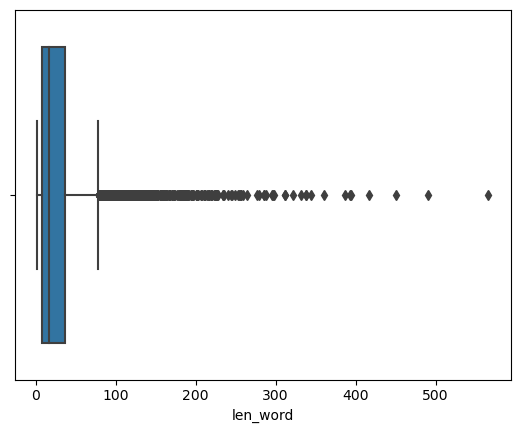

In [39]:
sns.boxplot(df['len_word'])

In [40]:
print('Q1:', df['len_word'].quantile(q=0.25))
print('Q2:', df['len_word'].quantile(q=0.5))
print('Q3:', df['len_word'].quantile(q=0.75))

Q1: 8.0
Q2: 17.0
Q3: 36.0


In [41]:
print('Mean:', df['len_word'].mean())

Mean: 28.768629540811794


In [42]:
df['tokens'] = df['tokens'].apply(lambda x: ' '.join(x))

In [43]:
df['tokens'].values

array(['akses jalan sulit jangkau jalan tuji curug lumayan jauh',
       'jalan bnr bikin syahduu parkir lokasi curug lelahh hilang sampe lokasi',
       'minggu februari gas santai pakai motor dago jam sampe parkir curug jam disasarin gps gunung halu percaya gps sasarin ikut tunjuk jalan warga jalan cililin bagus jalan cor proyek jalan blom beres bolong jalan ati aja oke tiket motor tiket masuk parkir motor tagih pulang harga makan parkir nasi ayam sayur kacang gpp larisin guys kasi jual sana sepi oke star jalan kaki parkir full trek turun berat nih pulang jalan santai nikmat view jalan lumayan kudu ati ambil video curug menit jalan warung buka sayang sepi beli kesana turun orang pasang sepi curugnya bagus indah liat foto jalan bersih sampah kesana bapa tugas beres lapin duduk sasapu baguss sayang jembatan foto kayu bolong licin kena ciprat air lapuk kudu akalin tuh cari bahan kuat kena air pokok kudu hati pis rawan jatoh oke nanjak dikit ketemu ojek situ diskus istri jalan ojek aja d

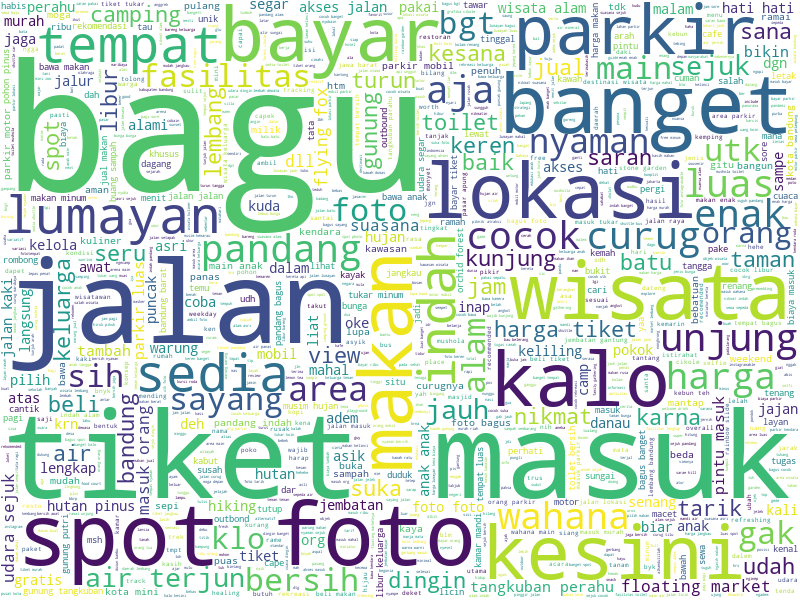

In [44]:
long_string = ''.join(df['tokens'].values)
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, 
                      contour_color='steelblue', width=800, height=600)
wordcloud.generate(long_string)

wordcloud.to_image()

# Data Transformation

## Bigram & Trigram Models

In [45]:
texts = df['tokens'].apply(lambda x: word_tokenize(x))
texts = texts.reset_index(drop=True)

In [46]:
bigram = Phrases(texts, min_count=10)
trigram = Phrases(bigram[texts])

for idx in range(len(texts)):
    for token in bigram[texts[idx]]:
        if '_' in token:
            texts[idx].append(token)
    for token in trigram[texts[idx]]:
        if '_' in token:
            texts[idx].append(token)

## Create corpus

In [47]:
# Initiate Corpus
id2word = corpora.Dictionary(texts)
id2word.filter_extremes(no_below=5, no_above=0.2)

# texts = df['tokens']
# corpus = [id2word.doc2bow(text) for text in texts]

In [48]:
# BoW Corpus
corpus = [id2word.doc2bow(text) for text in texts]

In [49]:
# id2word = corpora.Dictionary(df['tokens'])
# texts = df['tokens']
# corpus = [id2word.doc2bow(text) for text in texts]

In [50]:
# TF-IDF Corpus
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

# Apply Model

In [51]:
def compute_coherence_values(id2word, corpus, texts, start, limit, step):
    coherence_values = []
    model_list = []
    for num_topics in tqdm(range(start, limit, step)):
        model = LdaModel(
                    corpus=corpus, id2word=id2word, num_topics=num_topics, random_state=42, iterations=100,
                    # chunksize=2000, passes=1, update_every=1, alpha='symmetric', eta=None, 
                    # decay=0.5, offset=1.0, eval_every=10, gamma_threshold=0.001
                    )
        
        model_list.append(model)
        coherence_model = CoherenceModel(
                            model=model, texts=texts, dictionary=id2word, coherence='c_v')
        coherence_values.append(coherence_model.get_coherence())
        
    return model_list, coherence_values

In [66]:
START = 1
LIMIT = 21
STEP = 1

model_list, coherence_values = compute_coherence_values(
    id2word=id2word, corpus=corpus, texts=texts, start=START, limit=LIMIT, step=STEP)

100%|██████████████████████████████████████████████████████████████████████████████████| 20/20 [02:57<00:00,  8.87s/it]


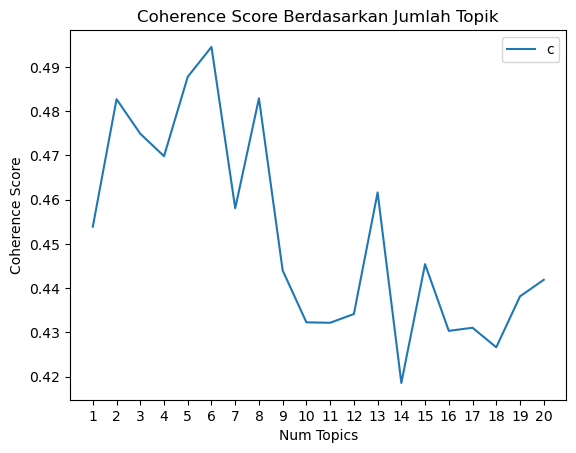

In [67]:
x = range(START, LIMIT, STEP)
plt.plot(x, coherence_values)
plt.title('Coherence Score Berdasarkan Jumlah Topik')
plt.xlabel('Num Topics')
plt.ylabel('Coherence Score')
plt.xticks(range(min(x), max(x)+1))
# plt.xlim(1, LIMIT-1)
# plt.xticks(coherence_values, x)
plt.legend(('coherence_values'), loc='best')
plt.show()

In [ ]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print(f'{cv:.3f}')
    # print(f'Num topics = {m}, has Coherence Score of {cv:.3f}')

In [ ]:
# model = LdaModel(corpus=corpus, id2word=id2word, num_topics=7)
model = model_list[5]

x = model.show_topics(num_topics=6, formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

# Below Code Prints Topics and Words
for topic, words in topics_words:
    print(f'Topic {topic}: {words}')
    
# for idx, topic in model.print_topics(-1):
#     print(f'Topic: {idx}, Word: {topic}')

In [ ]:
# len(model_list)

In [ ]:
num_topics = 7

lda_model = gensim.models.LdaMulticore(corpus=corpus, id2word=id2word, num_topics=num_topics, random_state=42)
coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
coherence_ldas = coherence_model_lda.get_coherence_per_topic()

print(f'Coherence Score with {num_topics} topic: {coherence_lda} \n')

# Below Code Prints Topics and Words
# for each_topic_coherence_score in enumerate(coherence_ldas):
#     print(f'Topic {each_topic_coherence_score[0]}: {each_topic_coherence_score[1]:.5f}')

x = lda_model.show_topics(num_topics=num_topics, formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

# Below Code Prints Topics and Words
for topic, words in topics_words:
    print(f'Topic {topic}: {words}')

In [ ]:
# NUM_TOPICS_OPTION = list(range(3, 11))
# # num_topics = 7

# for num_topics in NUM_TOPICS_OPTION:
#     lda_model = gensim.models.LdaMulticore(corpus=corpus,
#                                            id2word=id2word,
#                                            num_topics=num_topics,
#                                            random_state=42)

#     coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
#     coherence_lda = coherence_model_lda.get_coherence()
#     coherence_ldas = coherence_model_lda.get_coherence_per_topic()

#     print(f'Coherence Score with {num_topics} topic: {coherence_lda}')

#     #Below Code Prints Topics and Words
#     # for each_topic_coherence_score in enumerate(coherence_ldas):
#     #     print(f'Topic {each_topic_coherence_score[0]}: {each_topic_coherence_score[1]:.5f}')


#     x = lda_model.show_topics(num_topics=num_topics, formatted=False)
#     topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#     #Below Code Prints Topics and Words
#     # for topic, words in topics_words:
#     #     print(f'Topic {topic}: {words}')

In [ ]:
num_topics = 4

lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics,
                                       random_state=42)

coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
coherence_ldas = coherence_model_lda.get_coherence_per_topic()

print(f'Coherence Score with {num_topics} topic: {coherence_lda}')

# Below Code Prints Topics and Words
for each_topic_coherence_score in enumerate(coherence_ldas):
    print(f'Topic {each_topic_coherence_score[0]}: {each_topic_coherence_score[1]:.5f}')


x = lda_model.show_topics(num_topics=num_topics, formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

# Below Code Prints Topics and Words
for topic, words in topics_words:
    print(f'Topic {topic}: {words}')
    
# import gensim
# from pprint import pprint

# num_topics = 10

# lda_model = gensim.models.LdaMulticore(corpus=corpus_tfidf,
#                                        id2word=id2word,
#                                        num_topics=num_topics)

# pprint(lda_model.print_topics())
# doc_lda = lda_model[corpus]

In [ ]:
model = model_list[4]

In [ ]:
from sklearn.manifold import TSNE

# Mengambil matriks probabilitas topik untuk setiap dokumen
probabilitas_topik = np.zeros((len(corpus), 7))
for i, vektor_topik_dokumen in enumerate(model[corpus]):
    for topik, probabilitas in vektor_topik_dokumen:
        probabilitas_topik[i, topik] = probabilitas

# Melakukan reduksi dimensi menggunakan t-SNE
model_tsne = TSNE(n_components=2, random_state=42)
data_tsne = model_tsne.fit_transform(probabilitas_topik)

# Mendapatkan label topik untuk setiap dokumen
label_topik = [vektor_topik_dokumen.argmax() for vektor_topik_dokumen in probabilitas_topik]

# Plot visualisasi cluster t-SNE
plt.figure(figsize=(10, 6))
scatter = plt.scatter(data_tsne[:, 0], data_tsne[:, 1], c=label_topik)
plt.legend(*scatter.legend_elements(), title='Topik')
plt.xlabel('Dimensi 1')
plt.ylabel('Dimensi 2')
plt.title('Visualisasi Cluster Topik')
plt.show()

In [ ]:
probabilitas_topik

In [ ]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
# from bokeh.plotting import figure, output_file, show
# from bokeh.models import Label
# from bokeh.io import output_notebook

# Mengambil matriks probabilitas topik untuk setiap dokumen
topic_weights = np.zeros((len(corpus), num_topics))
for i, vektor_topik_dokumen in enumerate(lda_model[corpus]):
    for topik, probabilitas in vektor_topik_dokumen:
        topic_weights[i, topik] = probabilitas

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=42, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
plt.figure(figsize=(10, 6))
scatter = plt.scatter(tsne_lda[:, 0], tsne_lda[:, 1], c=topic_num)
plt.legend(*scatter.legend_elements(), title='Topik')
plt.xlabel('Dimensi 1')
plt.ylabel('Dimensi 2')
plt.title('Visualisasi Cluster Topik')
plt.show()

# n_topics = 4
# mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
# plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
#               plot_width=900, plot_height=700)
# plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])

In [ ]:
x = lda_model.show_topics(num_topics=10, formatted=False)
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

#Below Code Prints Topics and Words
for topic, words in topics_words:
    print(f'Topic {topic}: {words}')

#Below Code Prints Only Words 
# for topic,words in topics_words:
#     print(" ".join(words))

# Evaluate

In [ ]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)

In [ ]:
df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=corpus_tfidf, texts=texts)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic.head(10)

In [ ]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('Coherence Score: ', coherence_lda)

In [ ]:
coherence_model_lda = CoherenceModel(model=lda_model, texts=texts, dictionary=id2word, coherence='c_v')
coherence_ldas = coherence_model_lda.get_coherence_per_topic()

#Below Code Prints Topics and Words
for each_topic_coherence_score in enumerate(coherence_ldas):
    print(f'Topic {each_topic_coherence_score[0]}: {each_topic_coherence_score[1]:.5f}')

In [ ]:
for index, score in sorted(lda_model[corpus_tfidf[0]], key=lambda tup: -1*tup[1]):
    print("\nScore: {}\t \nTopic: {}".format(score, lda_model.print_topic(index, 10)))

In [ ]:
df.head()

In [ ]:
# df.to_excel("../dataset/dataset_preprocess.xlsx", index=False)

# Result

In [ ]:
# import pyLDAvis.gensim
# import pickle 
# import pyLDAvis
# # Visualize the topics
# pyLDAvis.enable_notebook()
# LDAvis_data_filepath = os.path.join('./results/ldavis_prepared_'+str(num_topics))
# # # this is a bit time consuming - make the if statement True
# # # if you want to execute visualization prep yourself
# if 1 == 1:
#     LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
#     with open(LDAvis_data_filepath, 'wb') as f:
#         pickle.dump(LDAvis_prepared, f)
# # load the pre-prepared pyLDAvis data from disk
# with open(LDAvis_data_filepath, 'rb') as f:
#     LDAvis_prepared = pickle.load(f)
# pyLDAvis.save_html(LDAvis_prepared, './results/ldavis_prepared_'+ str(num_topics) +'.html')
# LDAvis_prepared